In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2:
        return max(-(np.log(np.abs(x) -2) - 1), 0)
    elif x > 2:
        return min((np.log(np.abs(x) -2) - 1), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods)
    data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
data = run('NQ', ema, output=True, periods=[2,5,10,20,40,80,160,320,640])

weights: 
ema_2      0.152115
ema_5      0.107186
ema_10     0.092723
ema_20     0.086530
ema_40     0.083867
ema_80     0.084445
ema_160    0.095666
ema_320    0.122887
ema_640    0.174580

adjustments:
ema_2      16.389652
ema_5      10.606804
ema_10      7.585234
ema_20      5.270842
ema_40      3.764414
ema_80      2.850085
ema_160     2.419707
ema_320     2.007429
ema_640     1.648703

multiplier:
1.4613931703612444

correlations:
            ema_2     ema_5    ema_10    ema_20    ema_40    ema_80   ema_160  \
ema_2    1.000000  0.753053  0.442709  0.211338  0.080291 -0.001011 -0.058674   
ema_5    0.753053  1.000000  0.852204  0.544662  0.271394  0.077656 -0.055435   
ema_10   0.442709  0.852204  1.000000  0.854042  0.550747  0.250945  0.012030   
ema_20   0.211338  0.544662  0.854042  1.000000  0.859955  0.537902  0.179287   
ema_40   0.080291  0.271394  0.550747  0.859955  1.000000  0.850226  0.475788   
ema_80  -0.001011  0.077656  0.250945  0.537902  0.850226  1.000000  0.827

In [10]:
data.forecast.abs().mean(), data.forecast.abs().std()

(10.04919586860286, 6.429948645797937)

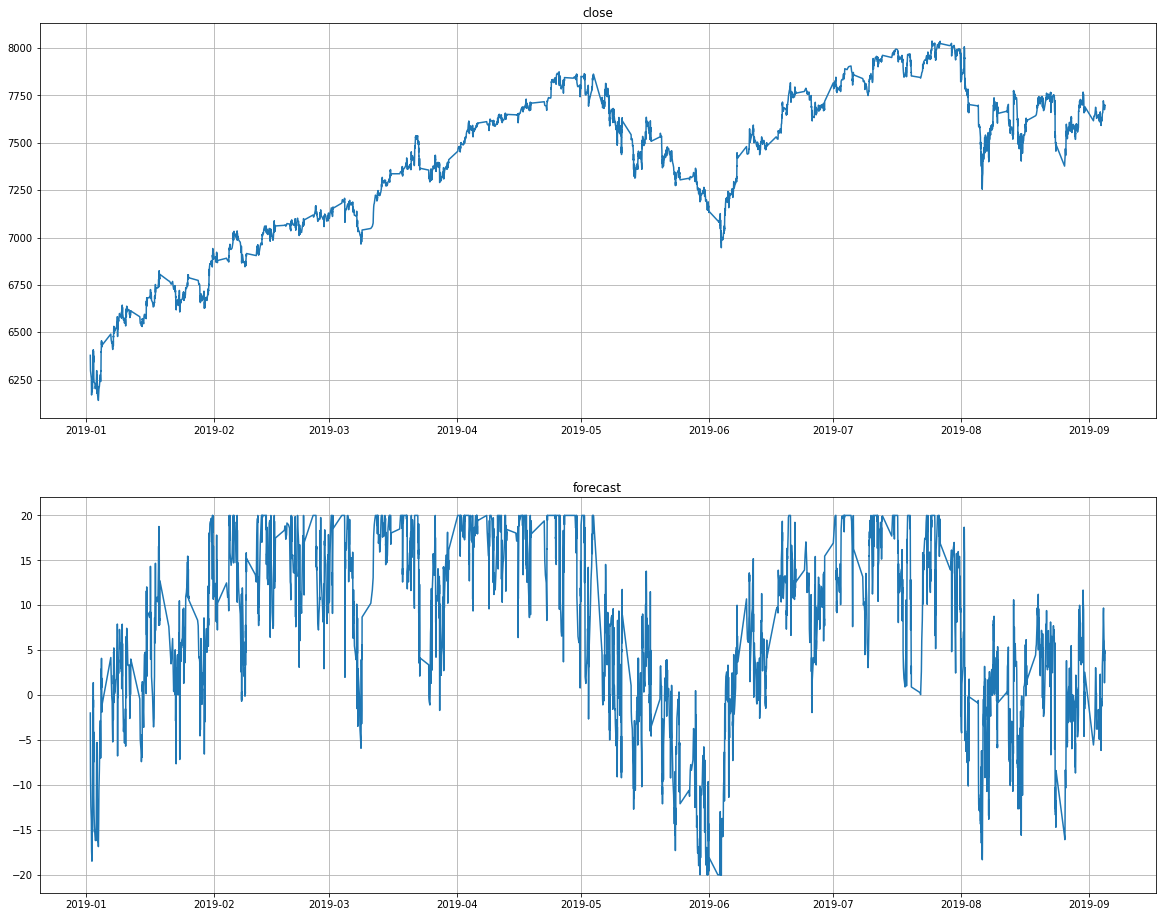

In [11]:
plot(data[['close', 'forecast']])

In [12]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.0952913,0.174388,0.0977381,0.147276,0.236415,0.210868,0.04474,0.0360398,-0.125162
Cumulative returns,0.0660188,0.119526,0.0676909,0.10131,0.160739,0.143841,0.0312193,0.02518,-0.0896447
Annual volatility,0.178575,0.160531,0.141555,0.130369,0.123451,0.105829,0.0768152,0.0633278,0.0527398
Sharpe ratio,0.598663,1.08139,0.729208,1.11884,1.781,1.86119,0.607975,0.590627,-2.50842
Calmar ratio,0.919266,2.61678,1.15372,2.38504,3.27858,4.8253,1.25583,0.78883,-1.39621
Stability,0.563194,0.874854,0.79297,0.857471,0.874255,0.858667,0.719062,0.435732,0.927611
Max drawdown,-0.10366,-0.0666422,-0.0847155,-0.06175,-0.0721091,-0.0437005,-0.0356258,-0.0456877,-0.0896447
Omega ratio,1.10433,1.19546,1.12682,1.20669,1.36689,1.39174,1.13643,1.15352,0.463348
Sortino ratio,0.845386,1.64756,1.10175,1.7499,2.90574,3.06344,0.976746,0.873668,-3.0451
Skew,-0.155308,0.088275,0.0959374,0.247236,0.280362,0.297566,0.366815,-0.241413,-1.39839


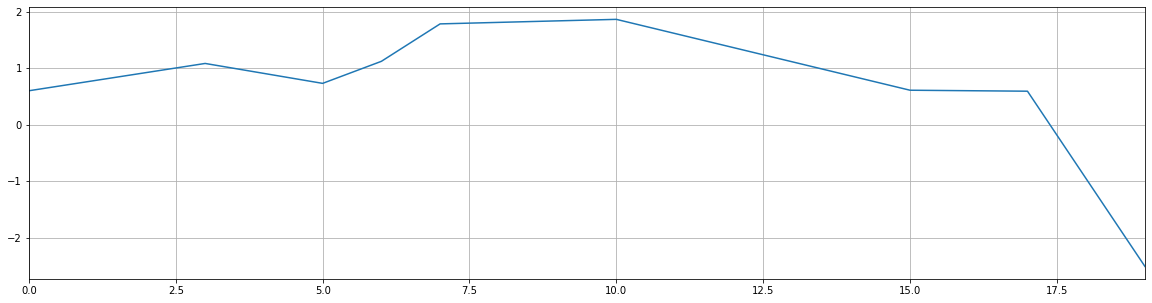

In [13]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [14]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.893356,0.818849,0.773163,0.733935,0.677391,0.455316,0.379312,0.208941
3,0.893356,1.000000,0.904700,0.855281,0.784852,0.701928,0.492046,0.384537,0.182024
5,0.818849,0.904700,1.000000,0.948498,0.868351,0.770732,0.574798,0.452215,0.217440
6,0.773163,0.855281,0.948498,1.000000,0.942486,0.819552,0.611472,0.499202,0.243831
7,0.733935,0.784852,0.868351,0.942486,1.000000,0.866610,0.647449,0.531109,0.288385
10,0.677391,0.701928,0.770732,0.819552,0.866610,1.000000,0.695980,0.561853,0.330732
15,0.455316,0.492046,0.574798,0.611472,0.647449,0.695980,1.000000,0.835945,0.561696
17,0.379312,0.384537,0.452215,0.499202,0.531109,0.561853,0.835945,1.000000,0.689882
19,0.208941,0.182024,0.217440,0.243831,0.288385,0.330732,0.561696,0.689882,1.000000


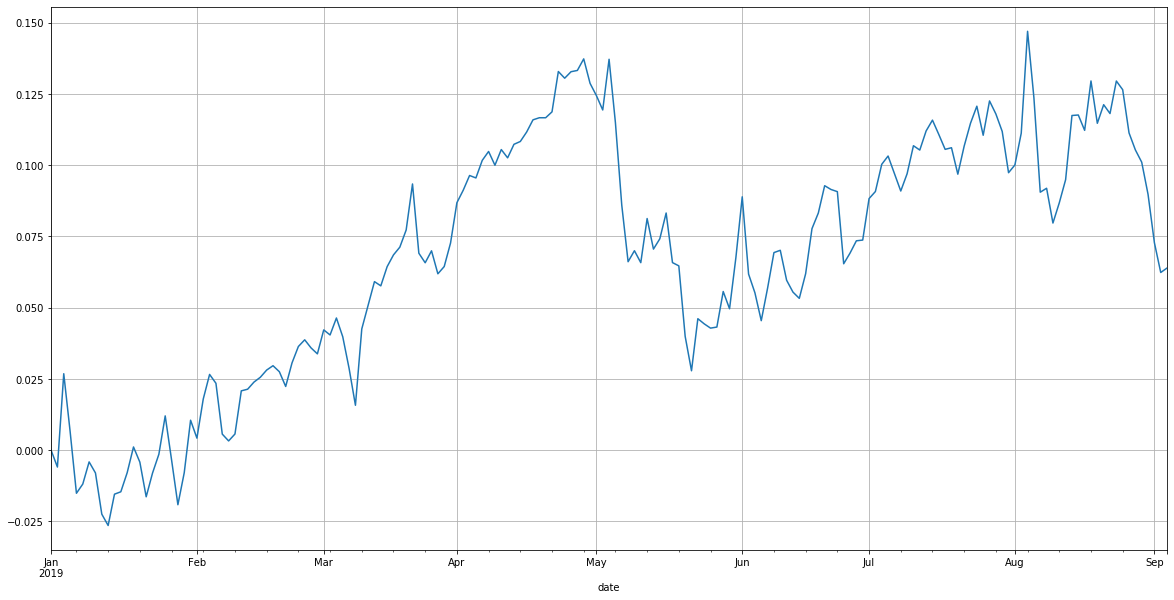

In [15]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

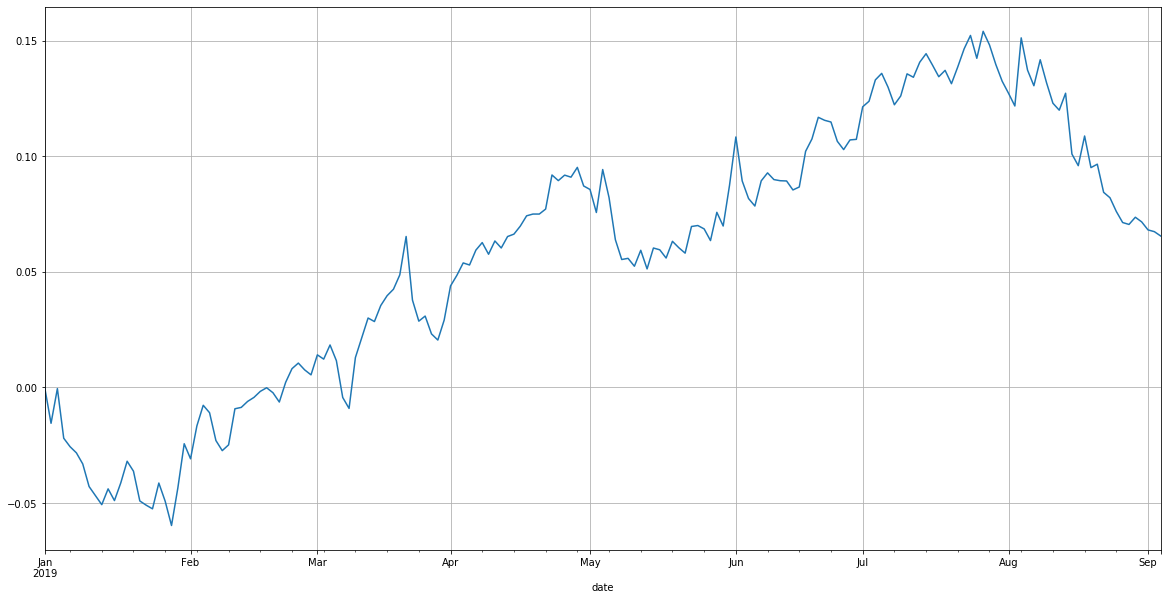

In [16]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

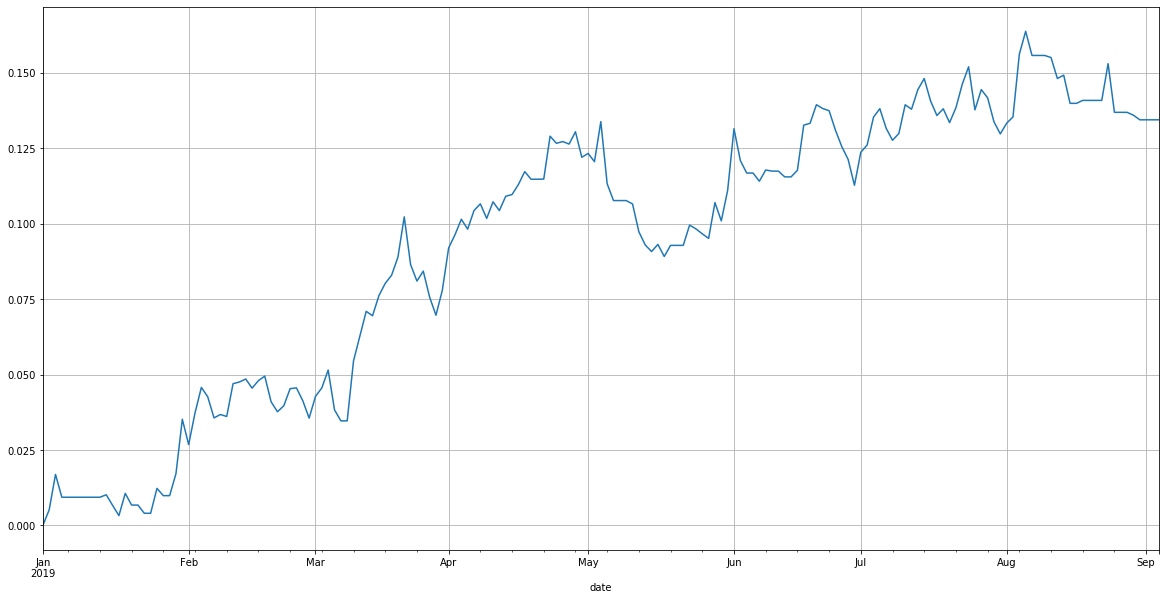

In [17]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);